In [7]:
#!pip install plotly --upgrade --user --quiet
#!pip install pandas --upgrade --user --quiet
#!pip install numpy --upgrade --user --quiet
#!pip install scipy --upgrade --user --quiet
#!pip install statsmodels --upgrade --user --quiet
#!pip install scikit-learn --upgrade --user --quiet
#!pip install missingno --upgrade --user --quiet
#!pip install apafib --upgrade  --quiet

In [8]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from time import time
from datetime import timedelta
init_time = time()

# APA - Ejercicio 1 - ¿Qué edad tienes?

## Load Inicial

En este problema trabajaré con el conjunto de datos Stroke Prediction Dataset, el cual contiene una descripcion de un conjunto de personas a partir de características demográficas, médicas y de hábitos. Esto será utilizado para predecir diferentes hechos a partir de este conjunto, principalmente la edad de las personas a partir de sus características personales.

La selección de este conjunto la obtendré utilizando la funcion load_stroke de la libreria apafib.

También cargaremos todos los imports necesarios para hacer todo el estudio y trabajo sobre nuestros datos.

In [10]:
from sklearn import datasets

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.__version__
from pandas.plotting import scatter_matrix
import missingno as msno


from sklearn import set_config

from sklearn.model_selection import train_test_split,  KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import warnings

from mpl_toolkits.mplot3d import Axes3D

from yellowbrick.regressor import AlphaSelection

from statsmodels.genmod.generalized_linear_model import GLM
import statsmodels.api as sm
from scipy import stats

set_config(display='text')
warnings.filterwarnings('ignore')

sns.set()
pd.set_option('display.precision', 3)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.precision', 3)


set_config(display='text')
warnings.filterwarnings('ignore')
pd.set_option('display.precision', 3)

'0.12.2'

In [11]:
from apafib import load_stroke
spd = load_stroke()

#hacemos un head para ver un poco como es el formato de la tabla inicialmente
spd.head()


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
1,33879,Male,42.0,0,0,Yes,Private,Rural,83.41,25.4,Unknown,1
2,14248,Male,48.0,0,0,No,Govt_job,Urban,84.20,29.7,never smoked,1
3,62602,Female,49.0,0,0,Yes,Private,Urban,60.91,29.9,never smoked,1
4,36338,Female,39.0,1,0,Yes,Private,Rural,58.09,39.2,smokes,1


## Apartado A

### Eliminar variables sin sentido

Una vez cargado hemos de eliminar las variables que no tiene sentido utilizar por aportar poco valor al objetivo de nuestro estudio, a priori no podriamos discernir entre claros elementos que no aporten mucho al resultado final más allá de evidentemente el id el cual no nos aporta nada sobre la informacion del individuo al que nos referimos.

El genero tampoco parece aportar demasiado a discernir en la edad de un individuo (tal vez si quisieramos ver probabilidad de otros aspectos de salud si pero en este caso no aporta nada).

Existen variables de estilo de vida que pueden parecer poco relevantes como el tipo de trabajo o tipo de residencia pero puesto que estas pueden estar relacionas con la edad a priori las mantendré.

Tras eliminar las que de momento se consideran poco relevante comodamente queda nuestra variable objetivo como la primera columna.

In [12]:
spd.drop(columns=['id', 'gender'], inplace=True)

### Dividir el conjunto en entrenamiento y test

Ahora procedo a dividir el conjunto de datos en entrenamiento y test con ratio de (70%/30%).

In [13]:
spd_train, spd_test = train_test_split(spd, test_size=0.3, random_state=0)

spd_train.shape, spd_test.shape

((1972, 10), (846, 10))

### Exploración rápida de las variables

Observaremos rápidamente un poco las variables del conjunto de entrenamiento mediante visualizacion para familiarizarnos con la distribución de las mismas.

Nos centraremos en observar la relaciond e variables con la variable objetivo, asimismo mirando de sacar alguna observacion que pueda resultar de interes para las posteriores fases del proyecto.

De primeras el tipo de residencia no promete mucho, lo conservé en caso de que por algún casual se viese reflejado el efecto de la huida hacia las ciudades y la desrtizacion de la zona rural pudiendo tener un rol en determinar mejor la edad peró están distribuidos de forma bastante igualitaria.

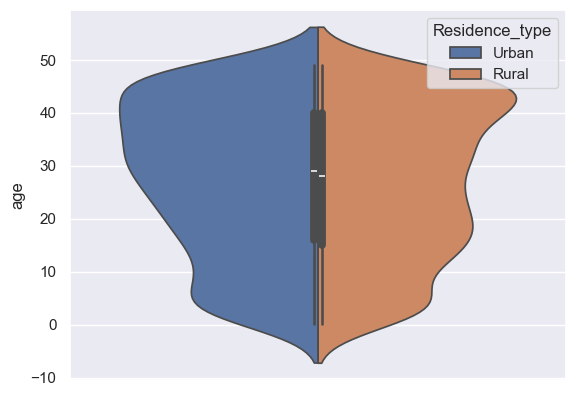

In [ ]:
sns.violinplot(data=spd_train, y="age", hue="Residence_type", split=True);

In [14]:
spd_train.drop(columns=['Residence_type'], inplace=True)
spd_test.drop(columns=['Residence_type'], inplace=True)

Los siguentes plots nos hacen ver que a priori las enfermedades o aspectos de estilo de vida que suceden de forma mas tardía (casarse por ejemplo) tienen un valor potencial para determinar como de mayor puede ser alguién.

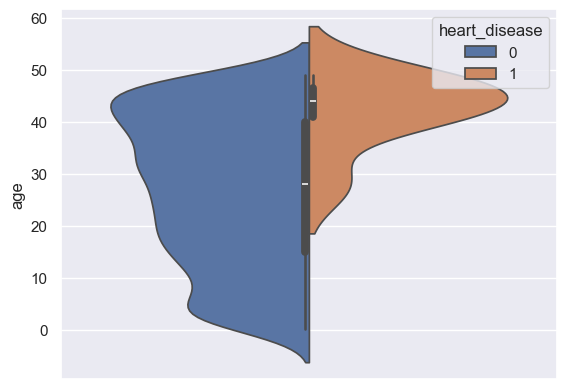

In [ ]:
sns.violinplot(data=spd_train, y="age", hue="heart_disease", split=True);

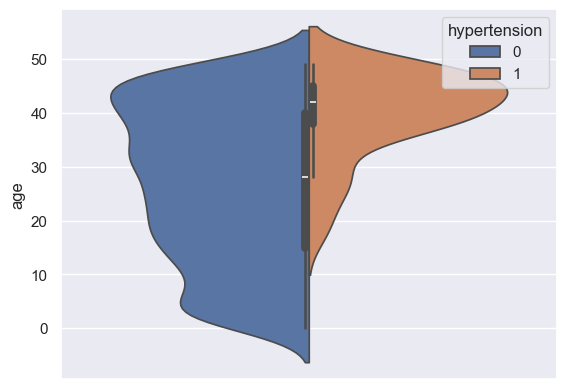

In [ ]:
sns.violinplot(data=spd_train, y="age", hue="hypertension", split=True);

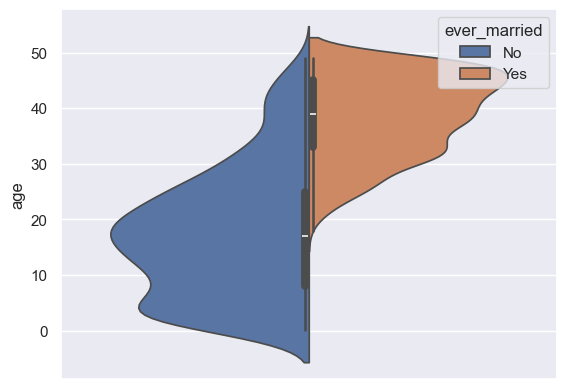

In [ ]:
sns.violinplot(data=spd_train, y="age", hue="ever_married", split=True);

Por otro lado, en el violin plot de fumar no parece que podamos decir mucho de el, pues no han preguntado a menores y la distribución entre los tres grupos de fumadores en adultos es bastante unifmorme sin seguir patrones claros. Más o menos lo mismo nos pasa con el tipo de trabajo, el cual evidentemente para niños se pone que estos no trabajan y entre los adultos se ve pocos patrones observables, con los adultos que trabajan en el govierno o de autónomos se ve un crecimiento hasta la adultez mas tardía pero poco más.

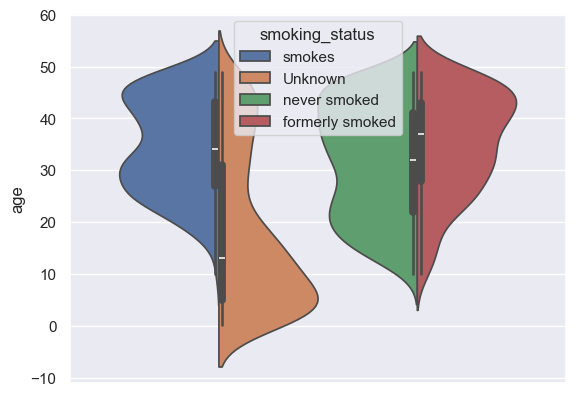

In [ ]:
sns.violinplot(data=spd_train, y="age", hue="smoking_status", split=True);

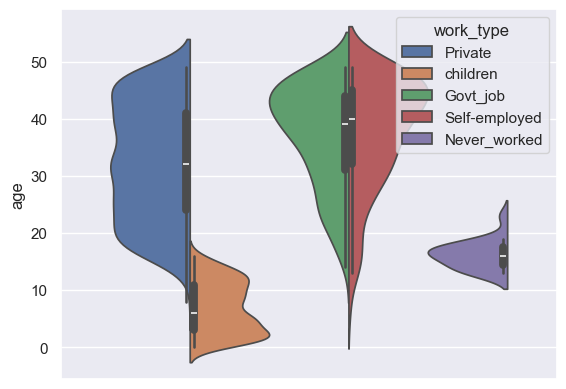

In [ ]:
sns.violinplot(data=spd_train, y="age", hue="work_type", split=True);

Aquí podemos ver que ninguna de las variables sigue una distribucion normal

In [15]:
from scipy.stats import normaltest

print(normaltest(spd_train['age'], nan_policy='omit'))
print(normaltest(spd_train['avg_glucose_level'], nan_policy='omit'))
print(normaltest(spd_train['bmi'], nan_policy='omit'))

NormaltestResult(statistic=986.1455274937219, pvalue=7.264730835549397e-215)
NormaltestResult(statistic=743.942813154428, pvalue=2.8501695616353273e-162)
NormaltestResult(statistic=550.5137433870757, pvalue=2.867210098150496e-120)


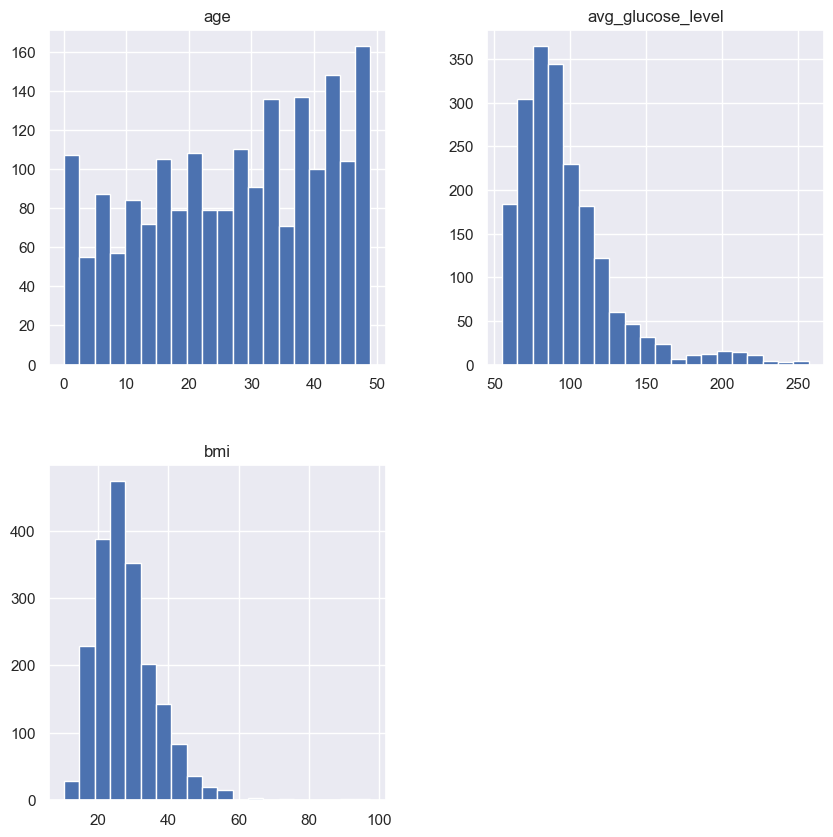

In [ ]:
spd_train.loc[:,['age', 'avg_glucose_level', 'bmi']].hist(bins=20, figsize=(10,10));

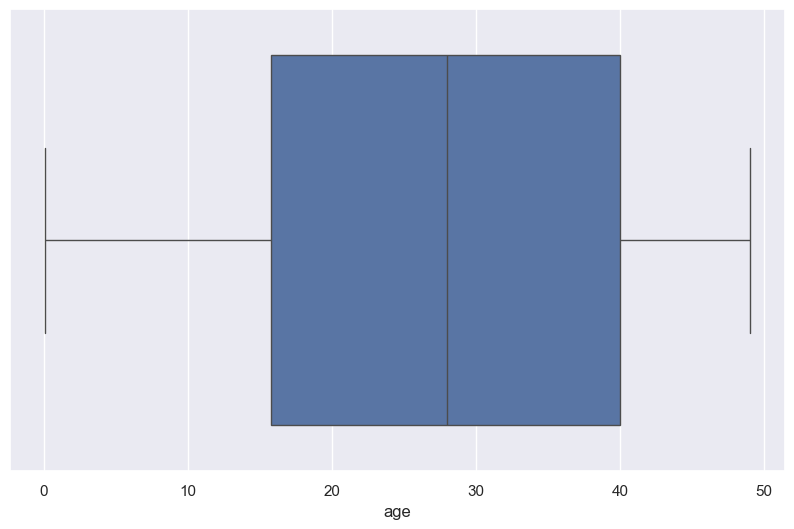

In [ ]:
plt.figure(figsize=(10,6));
sns.boxplot(data=spd_train, x="age");

Aquí se puede observar mucho sobre la correlación de las variables entre ellas.

Como es bien de esperar la edad tiene una correlación positiva con todos los aspectos de salud relevantes. Esto es bastante esperable puesto que a medida que se avanza en edad suelen aparecer diferentes condiciones físicas por desgaste. Esto es interesante para nuestro objetivo de predecir la edad con el estado de salud de una persona puesto que todas las variables tienen cierta correlacion con nuestra variable objetivo.

De entre ellas cabe destacar la hipertension y el indice de masa corporal (bmi en inglés) los cuales son los mas directamente relacionados con la edad siendo los otros claramente ralcionados pero mas sutiles. Adicionalmente, estos dos estan fuertemente relacionados entre ellos también.

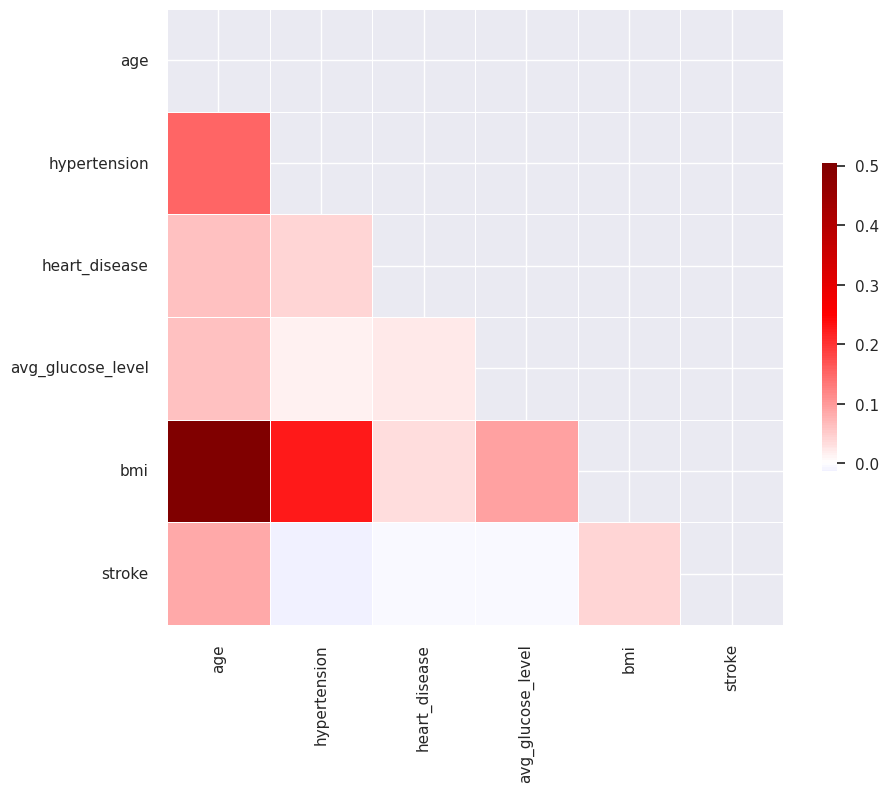

In [16]:
corr = spd_train.corr(numeric_only=True)
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=mask, cmap='seismic',  center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5});

### Transformación de las variables para ajustar al modelo de regresión (Preprocessing)

Ahora transformaremos las variables que no sean númericas en estas para poder procesarlas después

Las variables que hemos de cambiar són ever_married, work_type y smoking_status. Las dos primeras son booleanas así que basta con codificarlas con 1 o 0. El resto las convertiremos en sus propias variables binarias eliminando las que sean linealmente dependientes unas de otras (a veces pasa al descomponer variables así).

Estos cambios los tenemos que hacer para poder hacer tanto el PCA como el modelo de regresión LASSO.

In [17]:
# Define the mapping
smoking_status_mapping = {'smokes': 3, 'Unknown': 1, 'never smoked': 0, 'formerly smoked': 2}

# Map the 'smoking_status' column using the defined mapping
spd_train['smoking_status'] = spd_train['smoking_status'].map(smoking_status_mapping)

spd_train['ever_married'] = spd_train['ever_married'].astype('category').cat.codes

# Continue with one-hot encoding for 'work_type'
dummies1 = pd.get_dummies(spd_train['work_type'], drop_first=True, prefix='work_type', prefix_sep='_')

# Concatenate the one-hot encoded 'work_type' columns and the modified 'smoking_status' column
spd_train = pd.concat([spd_train, dummies1], axis=1)

# Drop the original 'work_type' column
spd_train.drop(columns=['work_type'], inplace=True)

# Convert the one-hot encoded columns to integers
spd_train[dummies1.columns] = spd_train[dummies1.columns].astype(int)

# Display the modified DataFrame
spd_train.head()

,age,hypertension,heart_disease,ever_married,avg_glucose_level,bmi,smoking_status,stroke,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children
206,29.0,0,0,0,207.58,22.8,3,0,0,1,0,0
2037,2.0,0,0,0,105.75,19.8,1,0,0,0,0,1
1824,42.0,0,0,1,80.00,27.5,0,0,0,1,0,0
2029,39.0,0,0,1,78.24,28.6,1,0,0,1,0,0
2441,42.0,0,0,1,67.97,23.8,1,0,0,0,0,0


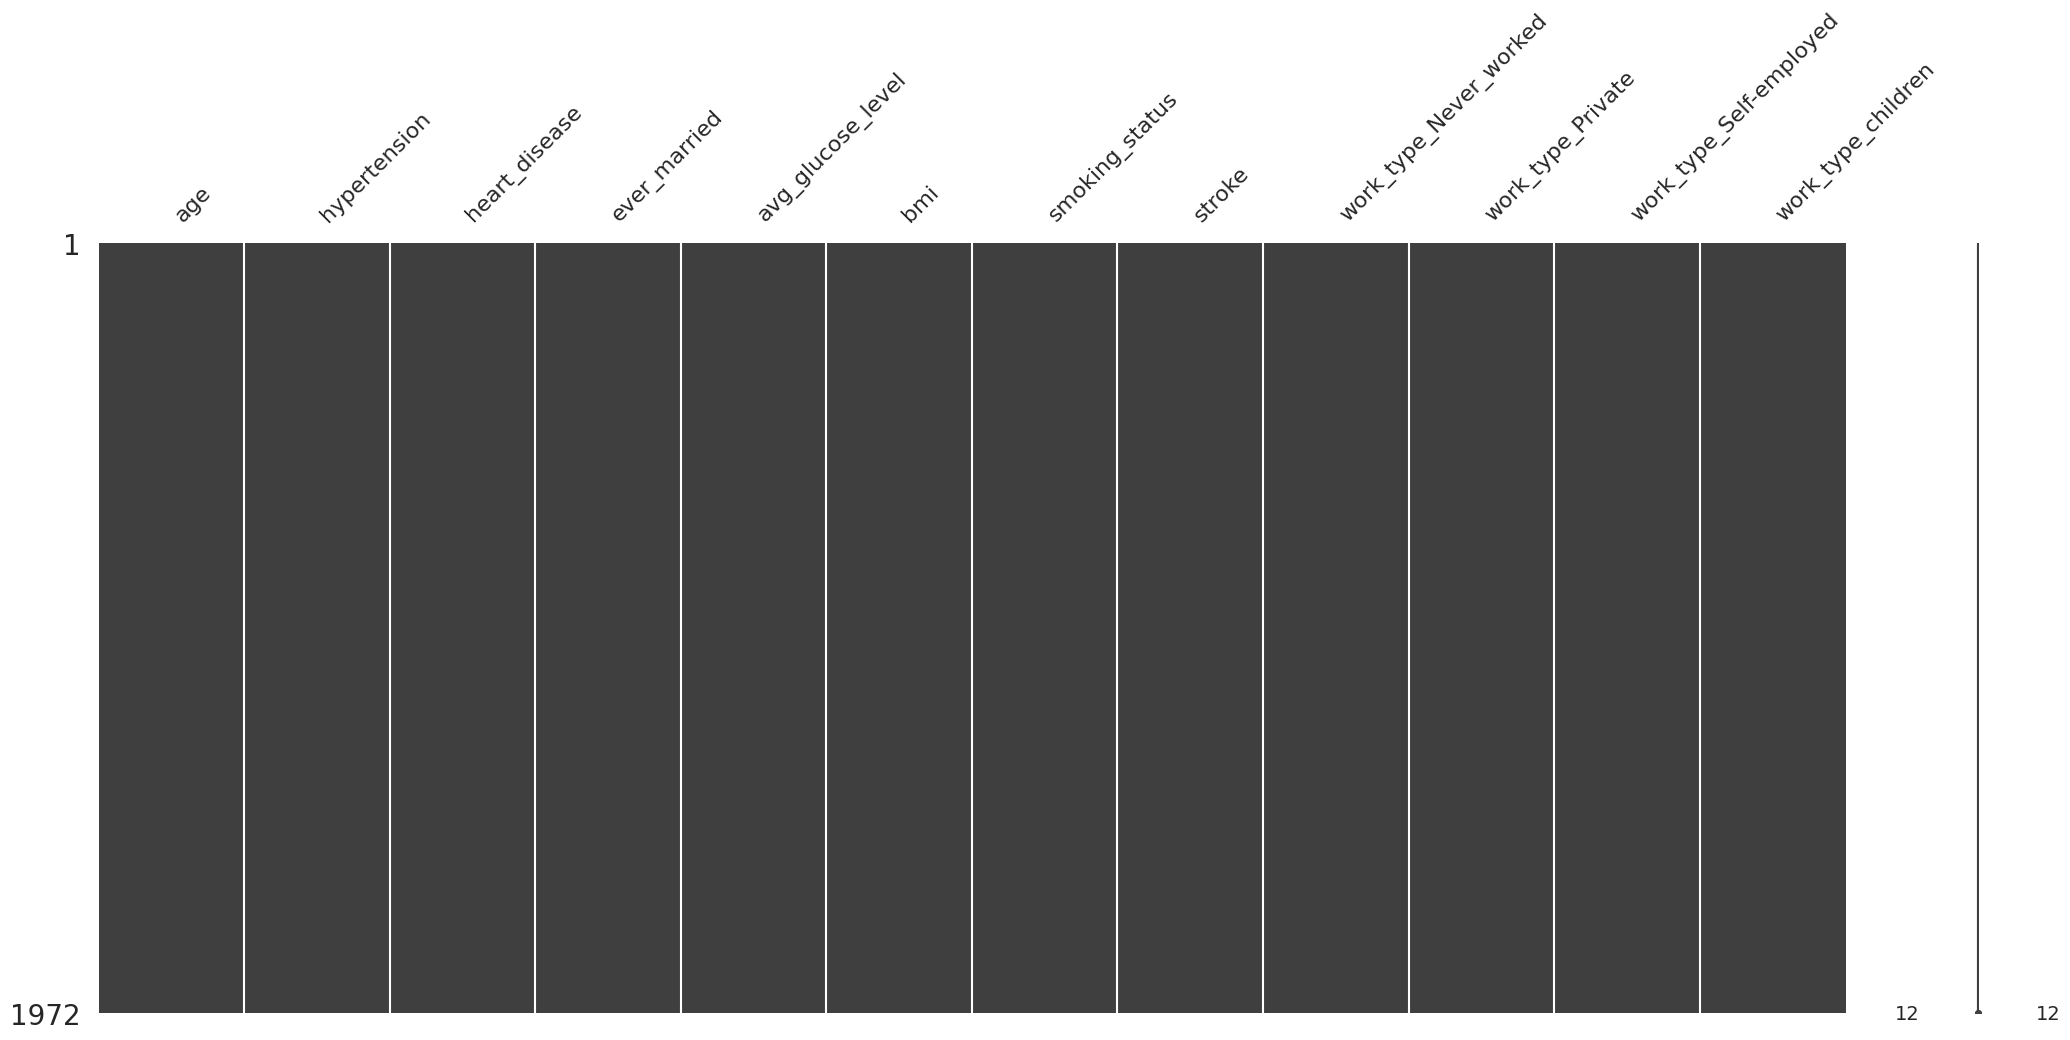

In [18]:
msno.matrix(spd_train);

In [19]:
# Define the mapping
smoking_status_mapping = {'smokes': 3, 'Unknown': 1, 'never smoked': 0, 'formerly smoked': 2}

# Map the 'smoking_status' column using the defined mapping
spd_test['smoking_status'] = spd_test['smoking_status'].map(smoking_status_mapping)

spd_test['ever_married'] = spd_test['ever_married'].astype('category').cat.codes

# Continue with one-hot encoding for 'work_type'
dummies1 = pd.get_dummies(spd_test['work_type'], drop_first=True, prefix='work_type', prefix_sep='_')

# Concatenate the one-hot encoded 'work_type' columns and the modified 'smoking_status' column
spd_test = pd.concat([spd_test, dummies1], axis=1)

# Drop the original 'work_type' column
spd_test.drop(columns=['work_type'], inplace=True)

# Convert the one-hot encoded columns to integers
spd_test[dummies1.columns] = spd_test[dummies1.columns].astype(int)

# Display the modified DataFrame
spd_test.head()

,age,hypertension,heart_disease,ever_married,avg_glucose_level,bmi,smoking_status,stroke,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children
2714,38.0,0,0,1,73.76,37.4,0,0,0,1,0,0
333,23.0,0,0,0,79.39,27.6,0,0,0,1,0,0
70,23.0,0,0,0,99.92,25.8,0,0,0,1,0,0
569,23.0,0,0,0,90.84,31.6,0,0,0,1,0,0
118,12.0,0,0,0,75.22,20.9,1,0,0,0,0,1


## Apartado B

### PCA

#### Explicación del procedimiento y objetivo del apartado

Una vez hemos preprocesado las variables y hemos hecho una exploración que nos permite entender un poco por donde van los tiros con la correlacion entre nuestra variable objetivo y el resto de vairbales ahora haremos el estudio de Principal Component Analysis.

El PCA nos permitira entender mejor como nuestras variables númericas se relacionan entre ellas obteniendo una diferente visualizacion de nuestro dataset. Esta nos permita reubicar nuestros datos sin perder informacion en una matriz de proyeccion que escalara y rotara nuestros datos en un espacio de nuevas dimensiones ortogonales (los componentes) que son combinaciones de los atributos iniciales.

Estos nuevos componentes estan ordenados por la informacion que contienen siendo el primero el que más información almacena. Esto es útil por el hecho de que nuestros datos estaran distribuidos a lo largo de estos nuevos ejes que almacenan la variancia del dataset de forma que se vean mejor.

Esta transformacion de datos luego nos permitirá eliminar estos componentes principales que albergan poca variabilidad (los que están más atrás en el orden, reduciendo la dimensionalidad gracias a esta transformación que hemos hecho.

#### Transformaciones previas

Para que el PCA funcione los datos han de estar estandarizados así que tenemos que hacer que todas las vairables tengan media 0 y desviacion estandar 1.

In [20]:
spd_standarized = spd_train.copy()
spd_standarized[spd_train.columns] = StandardScaler().fit_transform(spd_train)
spd_standarized.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1972.0,9.368e-17,1.0,-1.876,-0.790,0.059,0.891,1.515
hypertension,1972.0,3.873e-17,1.0,-0.173,-0.173,-0.173,-0.173,5.796
heart_disease,1972.0,-1.081e-17,1.0,-0.060,-0.060,-0.060,-0.060,16.755
ever_married,1972.0,1.540e-16,1.0,-0.915,-0.915,-0.915,1.092,1.092
avg_glucose_level,1972.0,4.648e-16,1.0,-1.301,-0.655,-0.228,0.388,5.051
bmi,1972.0,3.657e-16,1.0,-2.041,-0.704,-0.169,0.517,8.107
smoking_status,1972.0,4.887e-17,1.0,-0.998,-0.998,-0.014,-0.014,1.952
stroke,1972.0,1.621e-17,1.0,-0.075,-0.075,-0.075,-0.075,13.352
work_type_Never_worked,1972.0,-6.080e-17,1.0,-0.099,-0.099,-0.099,-0.099,10.139
work_type_Private,1972.0,-1.009e-16,1.0,-1.182,-1.182,0.846,0.846,0.846


In [21]:
myPCA = PCA().fit(spd_standarized[spd_train.columns]);

print(myPCA.explained_variance_ratio_)
print(myPCA.explained_variance_ratio_.cumsum())

[0.26010462 0.11474801 0.09072645 0.08670191 0.083119   0.0822883
 0.08026139 0.07335023 0.05271565 0.04754059 0.01849672 0.00994713]
[0.26010462 0.37485263 0.46557908 0.552281   0.63539999 0.7176883
 0.79794969 0.87129991 0.92401557 0.97155615 0.99005287 1.        ]


En el primer vector podemos ver la varianza que almacena cada uno de los compontentes principales.
Mientras que en el segundo podemos observar el acumulativo de los mismos, el cual nos puede servir para ver cuantos PCs necesitamos para albergar el 80%-90% o mas de la varianza.

En nuestro caso con unos 8-9 componentes podriamos recoger del 80 al 90 de la varianza lo cual es aceptable y un estandard bastante común.

Es curioso porque en el scree plot podemos ver dos elbows en puntos diferentes, uno en el primer componente (cosa que tiene sentido porque este almacena la gran mayoria de la varianza y otro hacia el noveno componente el cual nos da el umbral del 90% si miramos el grafico de la varianza explicada acumulativa.

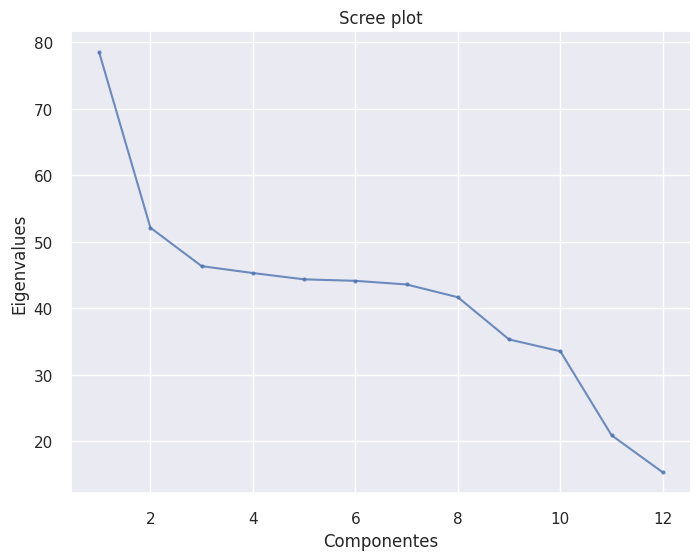

In [22]:
fig = plt.figure(figsize=(8,6));
plt.plot(range(1,len(myPCA.singular_values_ )+1),myPCA.singular_values_ ,alpha=0.8,marker='.');
y_label = plt.ylabel('Eigenvalues');
x_label = plt.xlabel('Componentes');
plt.title('Scree plot');

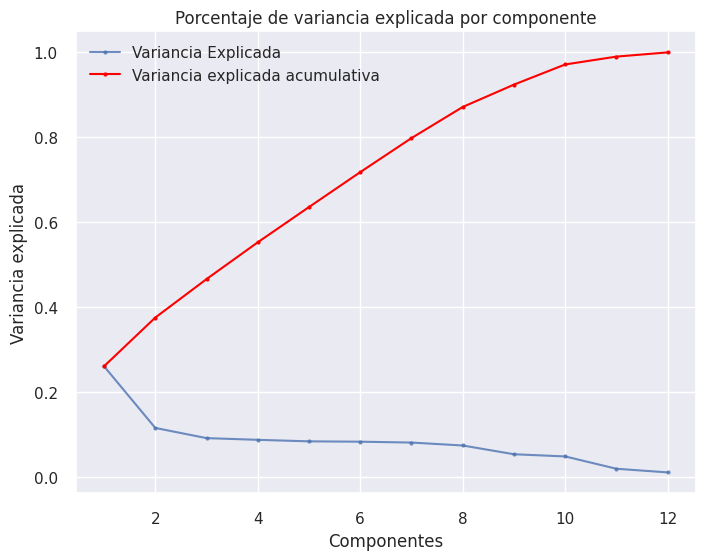

In [23]:
fig = plt.figure(figsize=(8,6));
plt.plot(range(1,len(myPCA.explained_variance_ratio_ )+1),myPCA.explained_variance_ratio_ ,alpha=0.8,marker='.',label="Variancia Explicada");
y_label = plt.ylabel('Variancia explicada');
x_label = plt.xlabel('Componentes');
plt.plot(range(1,len(myPCA.explained_variance_ratio_ )+1),
         np.cumsum(myPCA.explained_variance_ratio_),
         c='red',marker='.',
         label="Variancia explicada acumulativa");
plt.legend();
plt.title('Porcentaje de variancia explicada por componente');

Aquí podemos ver los pesos que aportan cada uno de nuestros atributos a los componentes principales encontrados mediante PCA.

Como podemos ver el primero (y el que más variabilidad almacena) esta fuertemente influenciado por la edad. Esto nos es de gran ayuda para nuestro trabajo puesto que la variable objetivo que tenemos es la edad por lo tanto que esta tenga un gran aporte de variablidad junto con otras variables que estan directa e inversamente relacionadas con PC1 y por tanto tambien tienen algo que ver con la edad. Esto nos ayudara mucho en nuestra labor predictiva.

Entonces respondiendo a la pregunta en cuestión si creo que pueda haber relacion entre las variables del conjuntod de datos y la variable objetivo y la justificación tiene que ver con los siguentes plots.

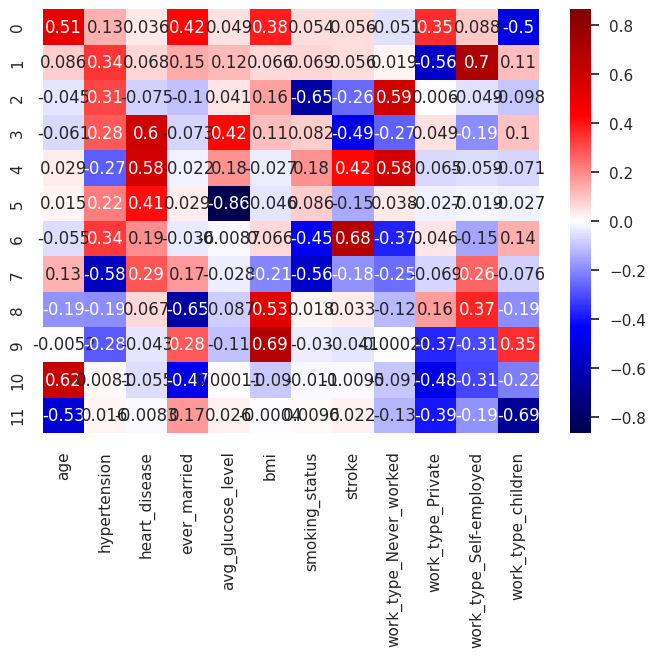

In [24]:
sns.heatmap(myPCA.components_, cmap='seismic',
            xticklabels=list(spd_train.columns),
            vmin=-np.max(np.abs(myPCA.components_)),
            vmax=np.max(np.abs(myPCA.components_)),
            annot=True);

En estos siguentes plots podemos ver como claramente a lo largo del eje de PC1 se distribuyen grupos donde la edad va aumentando gradualmente a medida que nos acercamos a los valores positivos. Además podemos ver que hay claras nubes donde se aglomeran menores de 10 años (con pocas dolencias fisicas y vidas mas sencillas sin trabajo ni fumar). Después hay nubes mas oscuras (gente mas mayor) y aquí vemos que forman diferentes nubes pues ya entran en juego factores más complejos de salud y puestos de trabajo.

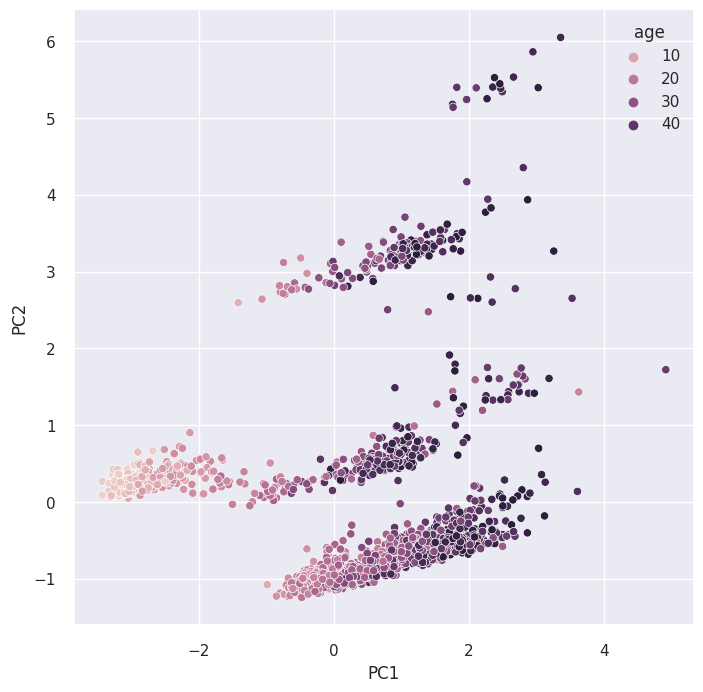

In [25]:
transformed_spd = myPCA.transform(spd_standarized[spd_train.columns])
spd_standarized[['PC1','PC2', 'PC3']] = transformed_spd[:,:3]
fig = plt.figure(figsize=(8,8))
_ = sns.scatterplot(x='PC1', y='PC2', data=spd_standarized, hue=spd_train['age'])

En la representacion tridimensional podemos ver con más dimensiones que la distribucion de la edad sigue de todas formas una direccion en el espacio de dimensiones a través de la cual se va distribuyendo.

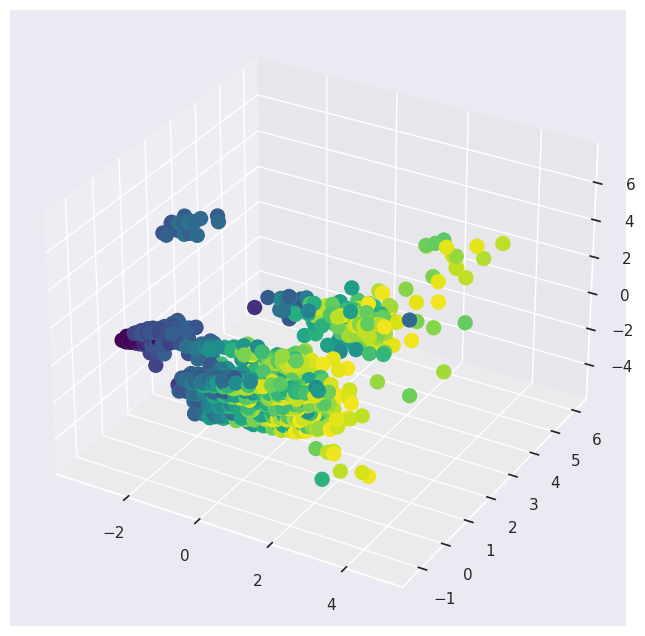

In [26]:
# Define the color range from green to red
color_range = np.linspace(0, 1, 256)

# Lambda function to map ages to a color gradient
color_mapping = lambda age: plt.cm.viridis((age - 0) / (50 - 0))

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')

# Use the lambda function to map colors based on age
scatter = ax.scatter(
    spd_standarized.PC1,
    spd_standarized.PC2,
    zs=spd_standarized.PC3,
    depthshade=False,
    c=spd_train['age'].apply(color_mapping),
    s=100
)

# Show the plot
plt.show()

In [27]:
import plotly.express as px
fig = px.scatter_3d(spd_standarized, x='PC1', y='PC2', z='PC3',
              color='age')
fig.show()

## Apartado C

### LASSO

#### Separar entre objetivo y otros

Ahora después del estudio de PCA separaremos la variable objetivo del resto y haremos los imports necesarios para ajustar el modelo de regresión LASSO para predecir la edad haciendo que nuestras predicciones de edad sean menos sensibles al reducido conjunto de entrenamiento disminuyendo la varianza global. Adicionalmente estimaremos la calidad de la regresión.

In [28]:
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.model_selection import cross_val_score
from yellowbrick.regressor import AlphaSelection
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

lambdas = [1e-4,1e-3,1e-2,0.1, 0.5,1,5,10,50,100]

X_train = spd_train.loc[:,spd_train.columns != 'age']
y_train = spd_train['age']

X_test = spd_test.loc[:,spd_test.columns != 'age']
y_test = spd_test['age']

In [29]:
lasso_cv =LassoCV(alphas=lambdas, cv=5).fit(X_train,y_train)

lasso_r2 =  np.mean(cross_val_score(lasso_cv, X_train,y_train))

print('Best lambda:', lasso_cv.alpha_,'R2 score:',lasso_r2)

Best lambda: 0.001 R2 score: 0.7634221029109026


La mejor lambda obtenida es igual a 0.001 y tiene un valor de R2 de 0.767634

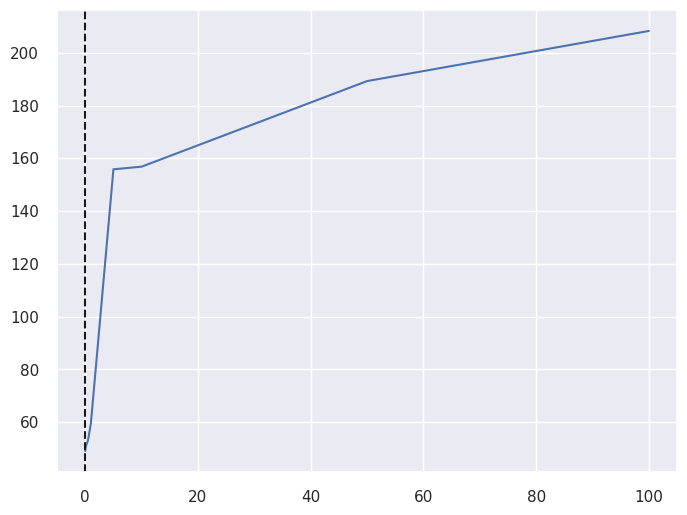

In [30]:
plt.figure(figsize=(8,6))
vis = AlphaSelection(LassoCV(alphas=lambdas));
vis.fit(X_train, y_train);

Aquí podemos observar la evolución de la selección del parámetro alfa.

In [31]:
r2_results = pd.DataFrame({'lasso_cv':lasso_r2},index=['CV R2'])

r2_results.loc['Train R2', :] =[r2_score(y_train,lasso_cv.predict(X_train))]

r2_results.loc['lambda','lasso_cv']=lasso_cv.alpha_

r2_results

,lasso_cv
CV R2,0.763
Train R2,0.766
lambda,0.001


Estos resultados nos muestran que la mejor lambda escojida para nuestro modelo LASSO ha estado 0.001. Este valor fue seleccionado tras hacer la validacion cruzada obteniendo así mismo el minimo MSE. Asímismo evitando hacer overfitting encontrando la mejor forma de regularizarlo.

Además el R2 (la medida estadística que indica lo bien que encaja todo cuantificando la varianza de la variable dependiente que es predecible a traves de las variables independientes). Esta R2 si bien no es espectacular (podría estar más cerca del 1), un 76% de la varianza explicada por nuestros datos de entrenamiento esta bastante bien para el proposito de descubrir la edad. Ya que los humanos a menudo tienen estilos de vida diversos o irracionales y estados de salud pocoa decuados a su edad por condiciones especiales.

Por lo tanto teniendo en cuenta este detalle disponemos de un modelo de regresion que se desenvolvera bastante bien y tiene cierto potencial predictivo con nuevos datos.

In [32]:
weights = pd.DataFrame({'lasso_cv':lasso_cv.coef_},index=X_train.columns)
weights.T

,hypertension,heart_disease,ever_married,avg_glucose_level,bmi,smoking_status,stroke,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children
lasso_cv,1.734,5.527,12.042,0.012,0.154,0.315,6.096,-10.723,-2.571,0.34,-19.44


En esta tabla podemos observar los diferentes pesos que nos aportancada uno de los atributos del dataset. Esto es especialmente interesante teniendo en cuenta el PCA hecho anteriormentepues nos corrobora que ciertas variables que esperabamos que fuesen relevantes lo son. Estas son ever_married, heart_disease y stroke. Curiosamente otras que apuntaban a aportar un valor bastante adecuado como bmi extrañamente aportan menos de lo que parece. Y algunas que cabia de esperar que aportaran de forma inversa como never_worked o children.

##Apartado D

### Error de la regresión

El error medio absoluto MAE es de mas o menos unos 5.35 años lo cual si lo ponemos en perspectiva no esta del todo mal. Puesto que aproxima de media bastante bien la edad de una persona. Pues fuera de lo que uno se pueda ofender, para un adulto promedio que se pasen o te quiten 5 años de media no es grave si esta predicción no se usa para aspectos críticos.

Por otro lado conseguimos un acierto de 0.790 aproximadamente lo cual es aceptable, no excepcional pero teniendo en cuenta como hemos dicho antes la complejidad de los humanos y la poca correlacion con la que trabajamos en primer lugar es lo mejor que se puede esperar.

Como podemos ver el MSE que intentamos minimizar es de 43.65.

In [35]:
y_tes_predicted = lasso_cv.predict(X_test)
r2_ridge = lasso_cv.score(X_test,y_test)

print('Mean sqared error with test data: {}'.format(mean_squared_error(y_test,y_tes_predicted)))
print('Mean absolute error with test data: {}'.format(mean_absolute_error(y_test,y_tes_predicted)))
print('R2 score with test data: {}'.format(r2_ridge))

Mean sqared error with test data: 43.653574918286324
Mean absolute error with test data: 5.357527823920892
R2 score with test data: 0.7895597130499628


###valores reales contra las predicciones para el conjunto de test

En este grafico se pueden ver estos grupos claramente separados que se aglomeran por edades, vemos que el best fit intenta acercarse más y acomodar a las predicciones de dades tardías pues la nube parece ser más numerosa y debe tener un papel importante en el error medio.

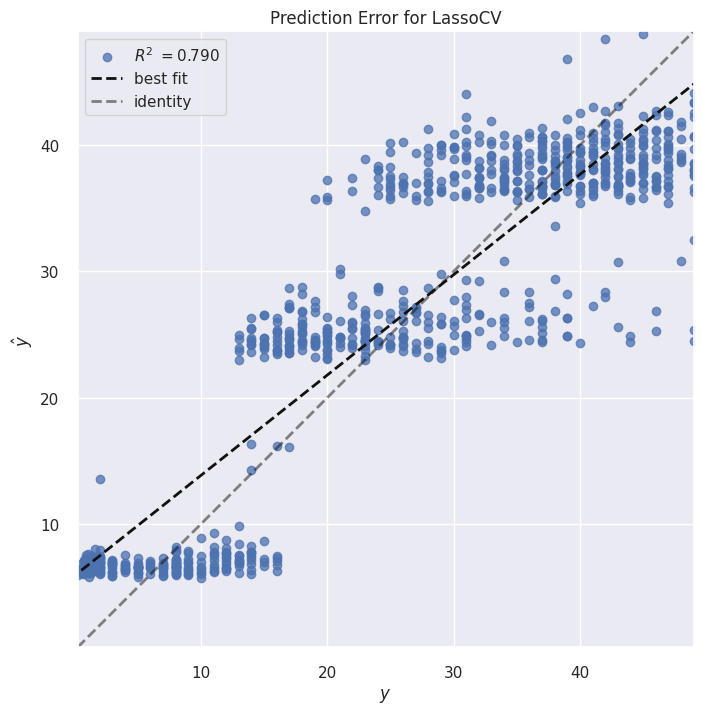

In [38]:
from yellowbrick.regressor import prediction_error

plt.figure(figsize=(8,8));
visualizer = prediction_error(lasso_cv, X_test, y_test, is_fitted=True);

##Residuos de la regresión

Observando los residuos de regresion podemos obtener una serie de informaciones relevantes que comentaré el origen que sospecho que tienen.

Los residuos siguen patrones interesantes. Se distribuyen en 3 grandes grupos los cuales se diferencian en edad. Podemos ver como ya nos habiamos imaginado por las variables y visto durante partes de visualizacion como el PCA que el grupo de los niños menores de diez años contiene unr esiduo mas recogido cosa que tiene sentido teniendo en cuenta que hay variables que directamente nos decian que alguien era un niño (las de fumar, trabajar etc.).

En cuanto a la gente joven entre 20 y 30 años, encontramos el máximo residuo de todos. Esto puede deberse al hecho de que a partir de los 20 los estilos de vida pueden variar muchisimo y hay menos indicadores que nos den pistas claras. Hay gente que se casa antes o despues, o que debuta de enfermedades en puntos diferentes, al igual como la masa corporal y aspectos como el trabajo. Toda esta variabilidad hace que sea más díficil predecir el valor correctamente como es muy de esperar.

Finalmente, el grupo de gente entre 30 y 50 años encontramos que este está algo mejor estimado que el anterior sin llegar tampoco a ser tan preciso como el de los niños. Esta nueva mejor predicción en este grupo se puede achacar a que ya la gente de esta franja de edad comienza a mostrar ciertos patrones de salud así como patrones de estilo de vida plenamente adulta más marcados (casarse, problemas de corazon, hypertension).

Con el Q-Q plot podemos ver que los residuales forman una distribucion normal, pues estos se acercan mucho a la linea ideal que podriamos esperar.

Como conclusion final el modelo obviamente tiene sus defectos que podriamos achacar a la incertidumbre que supone la variabilidad en ciertos aspectos de la conducta y la salud humanas. Si bien, este realmente se defiende bastante y es capaz de encontrar patrones y agrupar información para producir estimaciones satisfactorias para contextos poco críticos.

En un futuro se podria mirar un dataset mas complejo con otros factores de estilo de vida que puedan marcar mejor la edad pues junto a algunos aspectos de salud son los más relevantes para nuestra variable objetivo.

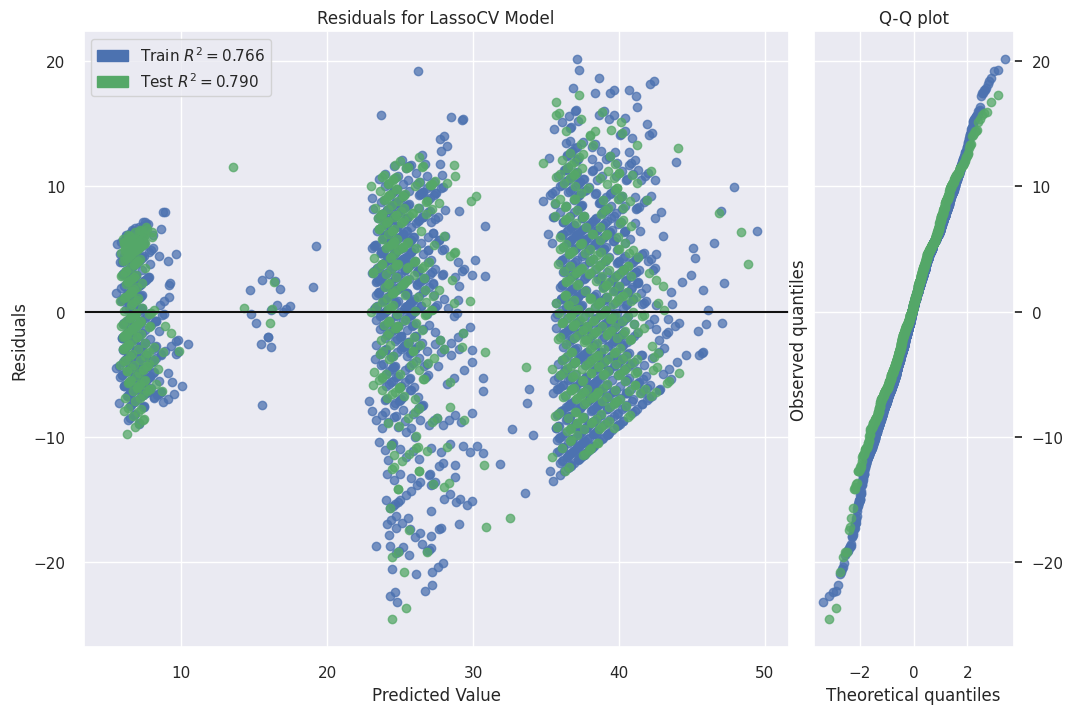

In [39]:
from yellowbrick.regressor import residuals_plot

plt.figure(figsize=(12,8));
viz = residuals_plot(lasso_cv, X_train, y_train, X_test, y_test, is_fitted=True, qqplot=True, hist=False);